# 📌 **Proyek Analisis Sentimen: Tahapan Scraping Review Aplikasi Google Play Store**

## 🔍 Tujuan
Proyek ini bertujuan untuk membangun model analisis sentimen berdasarkan review pengguna terhadap berbagai aplikasi populer di Google Play Store. Model yang dikembangkan akan mengklasifikasikan opini menjadi tiga kelas: **positif**, **netral**, dan **negatif**.

## 🗃️ Sumber Data
Data dikumpulkan secara mandiri menggunakan Python melalui library `google-play-scraper`. Scraping dilakukan pada 6 aplikasi besar lintas kategori:

- **Facebook** (`com.facebook.katana`) → Sosial media
- **Uber** (`com.ubercab`) → Transportasi online
- **YouTube** (`com.google.android.youtube`) → Platform video
- **Zoom** (`us.zoom.videomeetings`) → Video conference
- **Twitter (X)** (`com.twitter.android`) → Mikroblog & diskusi publik
- **Amazon Shopping** (`com.amazon.mShop.android.shopping`) → E-commerce

Pemilihan aplikasi didasarkan pada:
- Banyaknya jumlah review (hingga ratusan ribu)
- Mayoritas pengguna berbahasa Inggris (US-based)
- Potensi variasi opini dan polaritas sentimen yang seimbang

## ⚙️ Metodologi Scraping
- Digunakan fungsi `reviews_all()` dari `google-play-scraper` untuk mengambil semua review yang tersedia secara bertahap.
- Review disaring agar hanya menyertakan konten dan rating (score).
- Review kosong atau duplikat dihapus untuk menjaga kualitas data.
- Setiap aplikasi disimpan dalam file terpisah, kemudian digabung menjadi satu dataset besar.

## 📦 Hasil Akhir
- Total review terkumpul: **576.998 review unik**
- Format CSV: `raw_playstore_reviews.csv`
- Siap digunakan untuk preprocessing, pelabelan, dan pelatihan model klasifikasi sentimen.

---



## **1. Import dan Install Package Scraping yang Diperlukan Semuanya di Awal**

In [1]:
!pip install pipreqs==0.4.10
!pipreqs /content --force

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2de0ebc1383baccb15f291b8ee19f1840e83597c9c991d438b9f11cb313d1350
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
INFO: Successfully saved requirements file in /content/requirements.txt


In [24]:
!pip install google-play-scraper nltk
from google_play_scraper import reviews_all, Sort
import pandas as pd
import time
!pip install -q emoji==2.11.0   # versi stabil, kompatibel py3.10+
import re, unicodedata, html
from pathlib import Path
from typing import List

import pandas as pd, numpy as np
from tqdm import tqdm
import spacy, nltk, emoji
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Proses Scraping**

### **Funsi Scraping**

In [ ]:
# Fungsi untuk scraping review dari 1 aplikasi menggunakan reviews_all()
def scrape_reviews_all(app_id, app_name, lang='en', country='us'):
  print(f"Scraping {app_name} via reviews_all()...")

  # Ambil semua review dari Play Store berdasarkan ID aplikasi
  all_reviews = reviews_all(
      app_id=app_id,             # ID unik aplikasi di Play Store
      lang=lang,                 # Bahasa review (default: English)
      country=country,           # Lokasi pengguna (default: US)
      sort=Sort.MOST_RELEVANT,   # Urutkan review dari yang paling relevan
      count=500000               # Ambil maksimal 500k review
    )

  # Ubah hasil scraping jadi DataFrame pandas
  df = pd.DataFrame(all_reviews)

  # Ambil hanya kolom yang kita butuhkan: teks review & rating bintang
  df = df[['content', 'score']]

  # Hapus review yang kosong (tidak ada teks)
  df = df.dropna(subset=['content'])

  # Tambahkan kolom 'app' untuk menandai review ini berasal dari aplikasi mana
  df['app'] = app_name

  # Hapus review yang isinya sama (menghindari duplikat)
  df = df.drop_duplicates(subset='content')

  # Tampilkan jumlah review yang berhasil diambil dan disimpan
  print(f"{app_name} → {len(df)} review disimpan.")

  # Simpan hasil review per aplikasi ke file CSV
  df.to_csv(f"{app_name}_raw.csv", index=False)

  # Kembalikan DataFrame hasil scraping
  return df

### **Dict id APPS**

In [ ]:
# Dictionary berisi daftar aplikasi yang ingin di-scrape
apps = {
    'facebook': 'com.facebook.katana',
    'uber': 'com.ubercab',
    'youtube': 'com.google.android.youtube',
    'zoom' : 'us.zoom.videomeetings',
    'twitter' : 'com.twitter.android',
    'amazon_shop' : 'com.amazon.mShop.android.shopping'
}

### **Melakukan Scraping**

In [ ]:
dfs = []  # List kosong untuk menampung hasil scraping semua aplikasi

# Loop melalui setiap aplikasi dalam dictionary
for name, app_id in apps.items():
    # Panggil fungsi scraping untuk setiap aplikasi
    df = scrape_reviews_all(app_id, name)

    # Tambahkan hasilnya ke list dfs
    dfs.append(df)

    # Istirahat 2 detik antar aplikasi agar tidak dikira bot
    time.sleep(2)

# Gabungkan semua DataFrame hasil scraping menjadi satu DataFrame besar
df_all = pd.concat(dfs, ignore_index=True)

# Hapus review yang duplikat berdasarkan isi kontennya
df_all = df_all.drop_duplicates(subset='content')

# Tampilkan total review unik yang berhasil dikumpulkan
print("Total review unik:", len(df_all))

# Simpan semua review unik ke satu file CSV gabungan
df_all.to_csv("raw_playstore_reviews.csv", index=False)

Scraping facebook via reviews_all()...
facebook → 68093 review disimpan.
Scraping uber via reviews_all()...
uber → 80956 review disimpan.
Scraping youtube via reviews_all()...
youtube → 62910 review disimpan.
Scraping zoom via reviews_all()...
zoom → 71933 review disimpan.
Scraping twitter via reviews_all()...
twitter → 77044 review disimpan.
Scraping amazon_shop via reviews_all()...
amazon_shop → 131404 review disimpan.
Total review unik: 492082



---



# 🧹 **Preprocessing & EDA — Sentiment Analysis Google Play Reviews**

Pada bagian ini melanjutkan ke tahapan selanjutnya yaitu:

*   **Preprocessing** review teks mentah hasil scraping
*   **Eksplorasi data (EDA)** sederhana untuk memahami distribusi panjang teks, n-gram, dan skor rating

File sumber: `raw_playstore_reviews.csv`  
Total review: ~721.818 (hasil scraping dari 6 aplikasi lintas domain)


### Download Resource NLTK

In [4]:
# Download resource yang diperlukan
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Load Dataset

In [5]:
df = pd.read_csv("raw_playstore_reviews.csv")
df = df.drop_duplicates(subset=["content"]).reset_index(drop=True)
df["n_words"] = df["content"].str.split().str.len()

print("Jumlah total review:", len(df))
df.head()


Jumlah total review: 492082


,content,score,app,n_words
0,pretty terrible anymore. it's ad after ad. in ...,1,facebook,89
1,I used to love this app. But with the most rec...,2,facebook,91
2,"This app used to be great, but now it's just b...",1,facebook,76
3,"only some videos can be muted, and that is nev...",1,facebook,71
4,it's Facebook in alls it's good and bad. howev...,1,facebook,92


Text(0.5, 1.0, 'n_words awal')

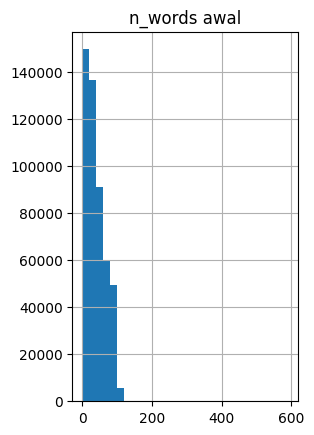

In [6]:
plt.subplot(1,2,1); df["n_words"].hist(bins=30); plt.title("n_words awal")

### Filter 4 < n_words ≤ 20

In [7]:
df = df[(df["n_words"] > 4) & (df["n_words"] <= 20)].reset_index(drop=True)
print("Jumlah total review setelah di filter 1–20 kata :", len(df))

Jumlah total review setelah di filter 1–20 kata : 133711


Text(0.5, 1.0, 'n_words 1-20')

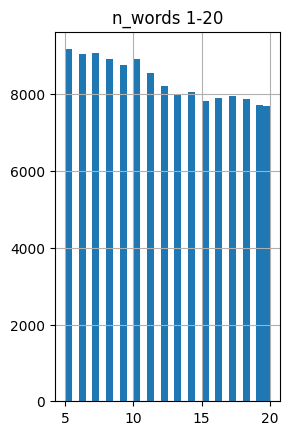

In [8]:
plt.subplot(1,2,2); df["n_words"].hist(bins=30); plt.title("n_words 1-20")

## Cleaning Fungsi + Eksekusi

### Global Resources

In [9]:
STOPWORDS = set(stopwords.words('english'))   # semua stopword
NEGATIONS = {
    "no", "not", "nor", "never", "n't", "cannot", "can't","wont",
    "wouldn't", "couldn't", "shouldn't", "isn't", "aren't",
    "haven't", "hasn't", "hadn't", "doesn't", "don't", "didn't",
    "won't", "wouldnt", "couldnt", "shouldnt", "isnt", "arent",
    "havent", "hasnt", "hadnt", "doesnt", "dont", "didnt",
    "hardly", "barely", "scarcely", "seldom", "rarely", "nothing",
    "nobody", "nowhere", "none", "lack", "lacks", "lacking",
    "fail", "fails", "failed", "without", "unable", "unhappy",
    "disappointed",
}
STOPWORDS = STOPWORDS - NEGATIONS             # keep negations

additional_stopwords = {
    "app", "amazon", "facebook", "youtube", "twitter", "uber", "tiktok", "zoom", # Nama aplikasi
    "use", "get", "time", "work", "service", "shop", "need", "can", "video",
    "online", "open", "phone", "keep", "new", "even",
    "thank", "please", "show"
}

STOPWORDS.update(additional_stopwords)

# spaCy pipeline (tanpa NER & parser → lebih cepat)
NLP = spacy.load("en_core_web_sm", disable=["ner","parser"])

# VADER analyzer
SIA = SentimentIntensityAnalyzer()


### Fungsi Preprocessing

In [10]:
def strip_html(text: str) -> str:
    """Menghapus semua tag HTML dari teks."""
    return re.sub(r"<.*?>", " ", text)

def normalize_for_vader(text: str) -> str:
    """
    Melakukan preprocessing teks khusus untuk VADER.
    Mempertahankan kapitalisasi dan angka yang penting bagi VADER.
    """
    # 1. Unescape HTML entities & normalisasi Unicode
    text = html.unescape(text)
    text = unicodedata.normalize("NFKD", text)

    # 2. Hapus URL / mention / hashtag (ganti dengan spasi agar tidak menyatukan kata)
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[@#]\w+", " ", text)

    # 3. Hapus emoji
    text = emoji.demojize(text) # Mengubah emoji menjadi representasi teks (e.g., :waving_hand:)
    text = re.sub(r':\S+?:', '', text) # Menghapus representasi teks emoji

    # 4. Pertahankan apostrof untuk kontraksi dan karakter alfanumerik (termasuk angka)
    #    Hapus karakter selain angka, huruf, apostrof, dan spasi.
    #    Ini juga menangani sisa-sisa karakter Unicode non-standar setelah normalisasi NFKD.
    text = re.sub(r"[^0-9A-Za-z\'\s]", " ", text)

    # 5. Normalisasi spasi: Ubah spasi berlebih menjadi spasi tunggal dan trim
    #    PENTING: TIDAK melakukan .lower() di sini agar VADER bisa memanfaatkan kapitalisasi.
    text = re.sub(r"\s+", " ", text).strip()

    return text

def spacy_clean(text: str) -> str:
    """
    Melakukan preprocessing lanjutan dengan SpaCy (lemmatization, stopword removal).
    Output dari fungsi ini TIDAK disarankan untuk langsung dilabeli VADER
    karena menghilangkan informasi penting (kapitalisasi, angka, stopword tertentu).
    Lebih cocok untuk input model ML/DL lain.
    """
    # Lakukan normalisasi dasar (bukan normalize_for_vader, karena kita akan melakukan
    # lemmatization dan stopword removal di sini)
    # ATAU, terima saja teks yang sudah bersih dari normalize_for_vader jika kamu ingin input yang konsisten
    doc = NLP(text.lower()) # Lakukan .lower() di sini karena lemmatization lebih baik pada lowercase

    tokens = [t.lemma_ for t in doc
              if (t.is_alpha and t.text not in STOPWORDS) # t.text.lower() untuk stopword check agar konsisten
              or t.lemma_ in NEGATIONS]
    return " ".join(tokens)

def remove_templates(df: pd.DataFrame, patterns: List[str] = None) -> pd.DataFrame:
    """Menghapus baris DataFrame yang mengandung pola template umum."""
    if patterns is None:
        patterns = ["thank you for", "thanks for your",
                    "feel free to", "contact our support",
                    "we appreciate your feedback"]
    pat = "|".join(patterns)
    # Menggunakan str.contains(case=False) agar tidak perlu .lower() di setiap teks
    return df[~df["content"].str.contains(pat, case=False, na=False)].reset_index(drop=True)

def vader_label(text: str, pos_th: float = 0.22, neg_th: float = -0.22) -> int:
    """Memberikan label sentimen (0: negatif, 1: netral, 2: positif) berdasarkan skor VADER."""
    c = SIA.polarity_scores(text)["compound"]
    if c > pos_th:    return 2      # positive
    if c < neg_th:    return 0      # negative
    return 1                        # neutral


### Proses Cleaning

In [11]:
# --- Proses Pipeline ---
tqdm.pandas(desc="cleaning")
print("1. Menghapus baris duplikat...")
df = df.drop_duplicates(subset=["content"]).reset_index(drop=True)
print(f"   Jumlah baris setelah menghapus duplikat: {len(df)}")
# Optional: print("--- DataFrame Setelah Menghapus Duplikat ---")
# Optional: print(df.head()) # Tampilkan beberapa baris awal

print("\n2. Menghapus template dari teks...")
# Fungsi remove_templates sudah mengembalikan DataFrame baru dengan index reset
df_cleaned = remove_templates(df.copy())
print(f"   Jumlah baris setelah menghapus template: {len(df_cleaned)}")
# Optional: print("\n--- DataFrame Setelah Menghapus Template ---")
# Optional: print(df_cleaned.head())


print("\n3. Preprocessing teks untuk VADER (mempertahankan kapitalisasi & angka)...")
# Menggunakan .progress_apply() dari tqdm
df_cleaned['content_for_vader'] = df_cleaned['content'].progress_apply(strip_html).progress_apply(normalize_for_vader)

# Optional: print("\n--- Teks Diproses untuk VADER (Mempertahankan Kapitalisasi & Angka) ---")
# Optional: print(df_cleaned[['content', 'content_for_vader']].head())


print("\n4. Menghitung skor compound VADER...")
# Menambahkan kolom skor compound
df_cleaned['vader_compound_score'] = df_cleaned['content_for_vader'].progress_apply(lambda text: SIA.polarity_scores(text)["compound"])

print("\n5. Memberi label sentimen menggunakan VADER...")
# Memberi label sentimen (gunakan vader_label atau vader_label_tuned sesuai pilihan Anda)
# Kami akan menggunakan vader_label_tuned yang sudah dioptimalkan sebelumnya
df_cleaned['vader_sentiment_label'] = df_cleaned['vader_compound_score'].progress_apply(
    lambda c: (2 if c >= 0.33 else (0 if c <= -0.20 else 1)) # <--- pada proses ini sudah dilakukan berulang kali guna meminimalisir class imbalance
)

print("\n--- Hasil Pelabelan Sentimen VADER (dengan Skor Compound) ---")
print(df_cleaned[['content', 'content_for_vader', 'vader_compound_score', 'vader_sentiment_label']].head())


print("\n6. Preprocessing teks untuk SpaCy (untuk analisis/model lain)...")
# Hanya jalankan ini jika Anda benar-benar membutuhkan output SpaCy_clean
df_cleaned['content_for_spacy'] = df_cleaned['content_for_vader'].progress_apply(spacy_clean)

# Optional: print("\n--- Teks Diproses untuk SpaCy (untuk analisis/model lain) ---")
# Optional: print(df_cleaned[['content', 'content_for_vader', 'content_for_spacy']].head())

print("\nProses Pipeline Selesai!")

1. Menghapus baris duplikat...
   Jumlah baris setelah menghapus duplikat: 133711

2. Menghapus template dari teks...
   Jumlah baris setelah menghapus template: 133420

3. Preprocessing teks untuk VADER (mempertahankan kapitalisasi & angka)...


cleaning: 100%|██████████| 133420/133420 [00:14<00:00, 9510.51it/s] 



4. Menghitung skor compound VADER...


cleaning: 100%|██████████| 133420/133420 [00:22<00:00, 5998.35it/s] 



5. Memberi label sentimen menggunakan VADER...


cleaning: 100%|██████████| 133420/133420 [00:00<00:00, 994634.13it/s] 



--- Hasil Pelabelan Sentimen VADER (dengan Skor Compound) ---
                                             content  \
0  I don't get notifications on my phone, despite...   
1  This new app is not user friendly. it has too ...   
2  white screen logging out. constantly having to...   
3  absolutely brilliant. great therapy for the he...   
4  good, but there are many interruption either m...   

                                   content_for_vader  vader_compound_score  \
0  I don't get notifications on my phone despite ...                0.0000   
1  This new app is not user friendly it has too m...               -0.3875   
2  white screen logging out constantly having to ...                0.1027   
3  absolutely brilliant great therapy for the hea...                0.9055   
4  good but there are many interruption either me...               -0.7750   

   vader_sentiment_label  
0                      1  
1                      0  
2                      1  
3                      

cleaning: 100%|██████████| 133420/133420 [07:20<00:00, 303.16it/s]


Proses Pipeline Selesai!


In [12]:
# labeling otomatis
df_cleaned["vader_sentiment"] = df_cleaned["vader_sentiment_label"].map({0:"negative",1:"neutral",2:"positive"})

print(df_cleaned["vader_sentiment"].value_counts())

vader_sentiment
positive    61156
neutral     41540
negative    30724
Name: count, dtype: int64


In [13]:
df_cleaned.head()

,content,score,app,n_words,content_for_vader,vader_compound_score,vader_sentiment_label,content_for_spacy,vader_sentiment
0,"I don't get notifications on my phone, despite...",1,facebook,20,I don't get notifications on my phone despite ...,0.0000,1,not notification despite activation notificati...,neutral
1,This new app is not user friendly. it has too ...,1,facebook,19,This new app is not user friendly it has too m...,-0.3875,0,not user friendly many screen read everything ...,negative
2,white screen logging out. constantly having to...,1,facebook,13,white screen logging out constantly having to ...,0.1027,1,white screen log constantly install clear ever...,neutral
3,absolutely brilliant. great therapy for the he...,5,facebook,18,absolutely brilliant great therapy for the hea...,0.9055,2,absolutely brilliant great therapy head soul e...,positive
4,"good, but there are many interruption either m...",4,facebook,16,good but there are many interruption either me...,-0.7750,0,good many interruption either message short vi...,negative


In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133420 entries, 0 to 133419
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   content                133420 non-null  object 
 1   score                  133420 non-null  int64  
 2   app                    133420 non-null  object 
 3   n_words                133420 non-null  int64  
 4   content_for_vader      133420 non-null  object 
 5   vader_compound_score   133420 non-null  float64
 6   vader_sentiment_label  133420 non-null  int64  
 7   content_for_spacy      133420 non-null  object 
 8   vader_sentiment        133420 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 9.2+ MB


In [15]:
from collections import Counter
df_temp = df_cleaned.copy()
df_temp['temp_list'] = df_temp['content_for_spacy'].apply(lambda x:str(x).split())
# Use 'positive' instead of ['positive'] for comparison
positive_text = df_temp[df_temp['vader_sentiment']=='positive']['content_for_spacy']
# Use 'negative' instead of ['negative'] for comparison
negative_text = df_temp[df_temp['vader_sentiment']=='negative']['content_for_spacy']
# Use 'neutral' instead of ['neutral'] for comparison
neutral_text = df_temp[df_temp['vader_sentiment']=='neutral']['content_for_spacy']

Positive_sent = df_temp[df_temp['vader_sentiment']=='positive']  # Corrected comparison
Negative_sent = df_temp[df_temp['vader_sentiment']=='negative']  # Corrected comparison
Neutral_sent = df_temp[df_temp['vader_sentiment']=='neutral']  # Corrected comparison

In [16]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.to_csv('common_positive_words.txt', sep='\t', index=False)
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,17286
1,great,10299
2,love,10007
3,easy,8502
4,not,6582
5,like,3993
6,well,3773
7,nice,3130
8,always,2960
9,shopping,2727


In [17]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative.to_csv('common_negative_words.txt', sep='\t', index=False)
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,bad,5792
2,no,4003
3,update,3610
4,can,2763
5,problem,2714
6,good,1887
7,ad,1741
8,get,1577
9,work,1466
10,always,1279


In [18]:
#MosT common neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral.to_csv('common_neutral_words.txt', sep='\t', index=False)
temp_neutral = temp_neutral.iloc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,update,4310
2,can,4270
3,crash,2467
4,work,2458
5,good,2278
6,keep,2204
7,fix,2030
8,always,1619
9,order,1588
10,go,1559


---

In [19]:
OUT = Path("/content/df_cleaned1.csv")
df_cleaned.to_csv(OUT, index=False)
print("Dataset saved:", OUT, ", shape:", df.shape)

Dataset saved: /content/df_cleaned1.csv , shape: (133711, 4)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pkg_resources

packages = [
    "google-play-scraper",
    "nltk",
    "pandas",
    "tqdm",
    "spacy",
    "emoji",
    "matplotlib",
    "seaborn"
]

for pkg in packages:
    try:
        version = pkg_resources.get_distribution(pkg).version
        print(f"{pkg}=={version}")
    except:
        print(f"{pkg} not installed")


google-play-scraper==1.2.7
nltk==3.9.1
pandas==2.2.2
tqdm==4.67.1
spacy==3.8.7
emoji==2.11.0
matplotlib==3.10.0
seaborn==0.13.2


In [29]:
with open("requirements.txt", "w") as f:
    for pkg in packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except:
            f.write(f"# {pkg} not installed\n")

In [30]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>